<a href="https://colab.research.google.com/github/ctalamilla/uba-ceia-AMIA_tf/blob/main/AMIA_2024_TP_final_LDA_QDA_Grupo7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrantes


```
Ezequiel Eduardo,Maudet
```

```
Marcelo Adrián,Más Valdecantos
```

```
Cristian Patricio,Salinas Talamilla
```

```
Lucas Delfino,Fajardo
```

```
Sebastian,Carreras
```


**Los resultados en expresados en tiempos (milisegundos - ms) fueron realizados en las corridas realizadas. Deben tomarse a manera de referencia y en comparacion con los resultados de otros metodos.**

# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [ ]:
import numpy as np
from numpy.linalg import det, inv

In [ ]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [ ]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [ ]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [ ]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [ ]:
# hiperparámetros
rng_seed = 6543

In [ ]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [ ]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [ ]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [ ]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [ ]:
qda = QDA()

qda.fit(train_x, train_y)

In [ ]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

In [ ]:
%%timeit

qda.predict(test_x)

7.09 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

8.3 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


### Desarrollo Implementacion Base

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_iris

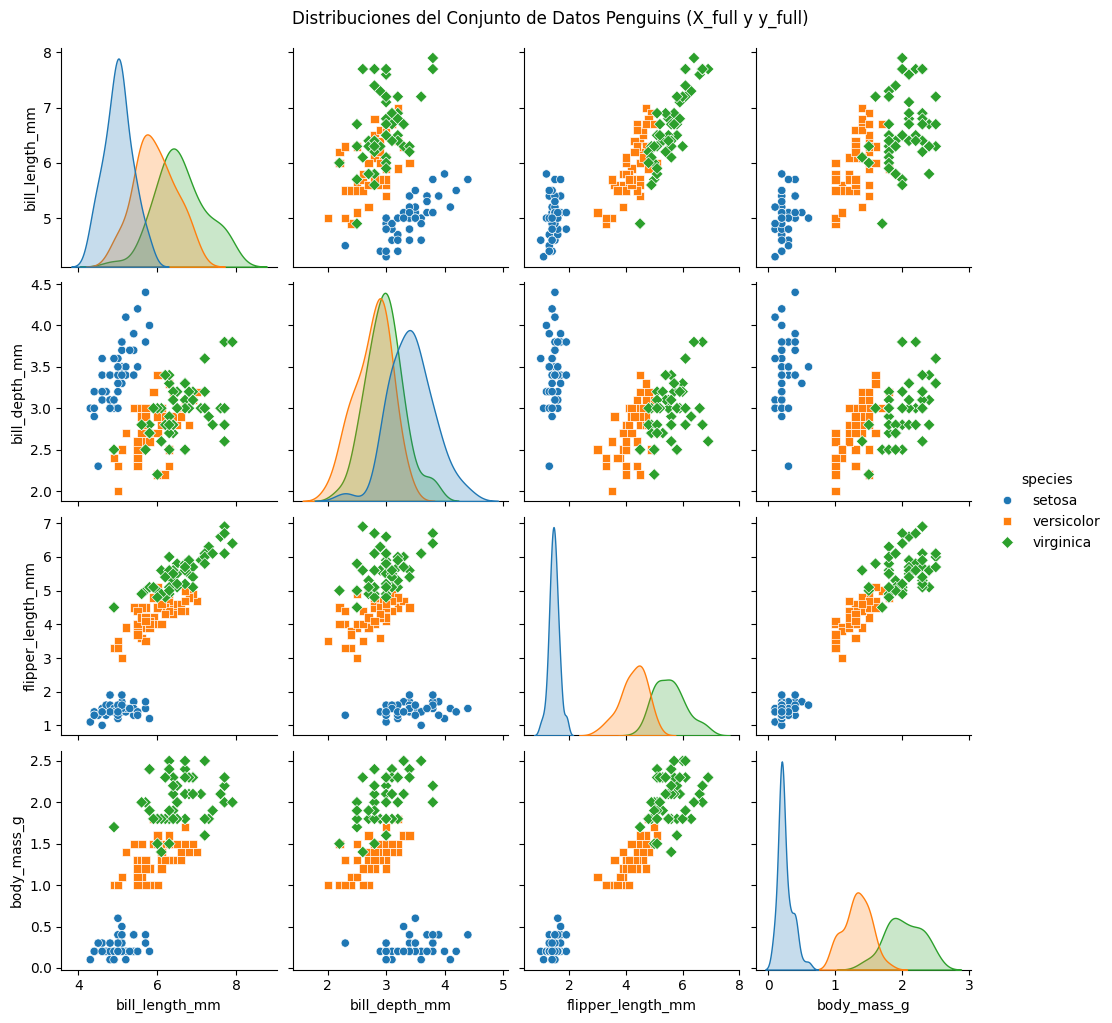

In [ ]:
# Crear un DataFrame con X_full y y_full para facilitar la visualización
def plot_penguins_distributions(X_full, y_full):
    # Crear un DataFrame a partir de X_full con los nombres de las columnas
    column_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
    df_X = pd.DataFrame(X_full, columns=column_names)

    # Añadir la columna de la clase (y_full) al DataFrame
    df_X['species'] = y_full.flatten()  # Asegurarse de que y_full esté en forma de vector

    # Visualizar las distribuciones de las características numéricas coloreadas por la clase (species)
    sns.pairplot(df_X, hue='species', markers=["o", "s", "D"])

    # Añadir un título general a la figura
    plt.suptitle('Distribuciones del Conjunto de Datos Penguins (X_full y y_full)', y=1.02)
    plt.show()

# Llamar a la función de graficar
plot_penguins_distributions(X_full, y_full)

In [ ]:
# Load Iris dataset
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)

# Load Penguins dataset
penguins, target = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

# Print the actual column names in the Penguins dataset
print(penguins.columns)

# Select only the numeric columns in Penguins using the correct column names
# Note: Adjust the column names below based on the output of print(penguins.columns)
X_penguins = penguins[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']]

# Calculate standard deviation for each feature in both datasets
std_iris = X_iris.std()
std_penguins = X_penguins.std()

# Display the standard deviations
print("Standard Deviation of Iris Dataset Features:")
print(std_iris)
print("\nStandard Deviation of Penguins Dataset Features:")
print(std_penguins)

# Compare dispersion
if std_iris.mean() > std_penguins.mean():
    print("\nThe Iris dataset has more dispersion on average.")
else:
    print("\nThe Penguins dataset has more dispersion on average.")

Index(['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')
Standard Deviation of Iris Dataset Features:
sepal length (cm)    0.828066
sepal width (cm)     0.435866
petal length (cm)    1.765298
petal width (cm)     0.762238
dtype: float64

Standard Deviation of Penguins Dataset Features:
culmen_length_mm       5.459584
culmen_depth_mm        1.974793
flipper_length_mm     14.061714
body_mass_g          801.954536
dtype: float64

The Penguins dataset has more dispersion on average.


#### 1 QDA / IRIS / Uniforme (1/3)

In [ ]:
import time
import pandas as pd

In [ ]:
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase setosa: 50 muestras
Clase versicolor: 50 muestras
Clase virginica: 50 muestras


In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
qda = QDA()
qda.fit(train_x, train_y, a_priori=uniform_priors)

In [ ]:
# QDA
start_time_train = time.time()
qda.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, qda.predict(train_x))
test_acc_qda = accuracy(test_y, qda.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results_1_Iris = {
    "Model": ["QDA"],
    "Seed": [42],
    "Set": ["IRIS"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_1_Iris_df = pd.DataFrame(results_1_Iris)

In [ ]:
results_1_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,IRIS,Uniform,0.011111,0.016667,7.339478,45.390606


#### 1 QDA / IRIS / Clase Mayoritaria

In [ ]:
# Definir las combinaciones para las clases dominantes
dominant_priors = [
    [0.9, 0.05, 0.05],  # Clase 0 dominante
    [0.05, 0.9, 0.05],  # Clase 1 dominante
    [0.05, 0.05, 0.9]   # Clase 2 dominante
]

In [ ]:
# Diccionario para almacenar los resultados
results = {
    "Model": ["QDA", "QDA","QDA" ],
    "Seed": [42, 42,42],
    "Set": ["IRIS","IRIS","IRIS"],
    "Dominant Class": [],
    "Train Error": [],
    "Test Error": [],
    "Training Time (ms)": [],
    "Prediction Time (ms)": []
}

In [ ]:
# Entrenar y evaluar el modelo con cada conjunto de priors dominantes
for idx, priors in enumerate(dominant_priors):
    qda_dominant = QDA()

    # Medir el tiempo de entrenamiento
    start_time_train = time.time()
    qda_dominant.fit(train_x, train_y, a_priori=priors)
    qda_train_time = time.time() - start_time_train

    # Medir el tiempo de predicción
    start_time_pred = time.time()
    train_acc_dominant = accuracy(train_y, qda_dominant.predict(train_x))
    test_acc_dominant = accuracy(test_y, qda_dominant.predict(test_x))
    qda_pred_time = time.time() - start_time_pred

    # Guardar los resultados en el diccionario
    results["Dominant Class"].append(f"Class {idx}")
    results["Train Error"].append(1 - train_acc_dominant)
    results["Test Error"].append(1 - test_acc_dominant)
    results["Training Time (ms)"].append(qda_train_time * 1000)
    results["Prediction Time (ms)"].append(qda_pred_time * 1000)


In [ ]:
# Convertir el diccionario a un DataFrame
results_1_b_Iris_df = pd.DataFrame(results)

In [ ]:
results_1_b_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Training Time (ms),Prediction Time (ms)
0,QDA,42,IRIS,Class 0,0.011111,0.016667,6.200790,31.032324
1,QDA,42,IRIS,Class 1,0.044444,0.050000,6.751299,38.668871
2,QDA,42,IRIS,Class 2,0.044444,0.016667,2.602339,25.317669


In [ ]:
results_1_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,IRIS,Uniform,0.011111,0.016667,7.339478,45.390606


#### Repuestas 1.
Entrenar un modelo QDA sobre el dataset iris utilizando las distribuciones a priori a continuación ¿Se observan diferencias?¿Por qué cree? Pista: comparar con las distribuciones del dataset completo, sin splitear.

*Diferencias en el desempeño:*

**Errores de entrenamiento y test:** Los errores de entrenamiento y de prueba son bajos en ambos casos, pero los modelos con clases dominantes a priori muestran errores ligeramente más altos (especialmente en Clase 1 y Clase 2) en comparación con el modelo de distribución uniforme.

**Tiempos de predicción:** Los tiempos de predicción son más altos en los modelos con clases dominantes a priori. Esto sugiere que la suposición de una clase mayoritaria impacta en el cálculo de las probabilidades durante la predicción, lo que podría incrementar la complejidad en el cálculo de las probabilidades condicionales en QDA.



*Comparación con la distribución del dataset completo:*

Si se observa la distribución del conjunto de datos completo sin dividir, las tres clases en el dataset IRIS tienen una proporción relativamente similar (aproximadamente 33% cada una). Por lo tanto, una distribución a priori uniforme debería reflejar mejor la naturaleza del conjunto de datos real.

Conclusión sobre las diferencias: Dado que las clases no están desbalanceadas en el conjunto de datos original, los modelos con distribución a priori sesgada (con una clase dominante) pueden estar introduciendo un sesgo no necesario, lo que afecta la capacidad del modelo para generalizar bien, lo que resulta en un error de prueba ligeramente mayor para las clases que no fueron elegidas como dominantes en ese modelo.



#### 2 QDA / Pinguin / Uniforme

In [ ]:
# showing for penguins
X_full, y_full = get_penguins()

print(f"X: {X_full.shape}, Y:{y_full.shape}")


X: (342, 4), Y:(342, 1)


In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase Adelie: 151 muestras
Clase Chinstrap: 68 muestras
Clase Gentoo: 123 muestras


In [ ]:
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
qda = QDA()
qda.fit(train_x, train_y, a_priori=uniform_priors)

In [ ]:
# QDA
start_time_train = time.time()
qda.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, qda.predict(train_x))
test_acc_qda = accuracy(test_y, qda.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results_1_Pinguins = {
    "Model": ["QDA"],
    "Seed": [42],
    "Set": ["Pinguin"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_2_Pinguin_df = pd.DataFrame(results_1_Pinguins)

In [ ]:
results_2_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,Pinguin,Uniform,0.009756,0.007299,4.371643,106.389284


#### 2 QDA / Pinguin / Clase Mayoritaria

In [ ]:
# Definir las combinaciones para las clases dominantes
dominant_priors = [
    [0.9, 0.05, 0.05],  # Clase 0 dominante
    [0.05, 0.9, 0.05],  # Clase 1 dominante
    [0.05, 0.05, 0.9]   # Clase 2 dominante
]

In [ ]:
# Diccionario para almacenar los resultados
results = {
    "Model": ["QDA", "QDA","QDA" ],
    "Seed": [42, 42,42],
    "Set": ["Pinguin","Pinguin","Pinguin"],
    "Dominant Class": [],
    "Train Error": [],
    "Test Error": [],
    "Training Time (ms)": [],
    "Prediction Time (ms)": []
}

In [ ]:
# Entrenar y evaluar el modelo con cada conjunto de priors dominantes
for idx, priors in enumerate(dominant_priors):
    qda_dominant = QDA()

    # Medir el tiempo de entrenamiento
    start_time_train = time.time()
    qda_dominant.fit(train_x, train_y, a_priori=priors)
    qda_train_time = time.time() - start_time_train

    # Medir el tiempo de predicción
    start_time_pred = time.time()
    train_acc_dominant = accuracy(train_y, qda_dominant.predict(train_x))
    test_acc_dominant = accuracy(test_y, qda_dominant.predict(test_x))
    qda_pred_time = time.time() - start_time_pred

    # Guardar los resultados en el diccionario
    results["Dominant Class"].append(f"Class {idx}")
    results["Train Error"].append(1 - train_acc_dominant)
    results["Test Error"].append(1 - test_acc_dominant)
    results["Training Time (ms)"].append(qda_train_time * 1000)
    results["Prediction Time (ms)"].append(qda_pred_time * 1000)


In [ ]:
# Convertir el diccionario a un DataFrame
results_2_b_Pinguin_df = pd.DataFrame(results)

In [ ]:
results_2_b_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Training Time (ms),Prediction Time (ms)
0,QDA,42,Pinguin,Class 0,0.024390,0.007299,8.931398,75.445890
1,QDA,42,Pinguin,Class 1,0.029268,0.029197,6.244659,88.013411
2,QDA,42,Pinguin,Class 2,0.009756,0.007299,1.967669,46.551704


In [ ]:
results_2_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,Pinguin,Uniform,0.009756,0.007299,4.371643,106.389284


#### Respuesta 2.

*Diferencias en el desempeño:*

**Errores de entrenamiento y test:** En todos los modelos se observan errores bajos tanto en el entrenamiento como en el test. Sin embargo, el modelo con clase dominante Clase 1 muestra un error de test más alto en comparación con los otros modelos, lo que sugiere que esta clase podría ser más difícil de predecir cuando se sesga el a priori hacia ella.

**Tiempos de entrenamiento y predicción:** Similar al caso anterior, los tiempos de predicción son mayores en los modelos con clases dominantes a priori, mientras que el modelo con a priori uniforme tiene un tiempo de predicción significativamente menor. Esto indica que la suposición de una clase dominante incrementa la carga computacional durante la predicción.


*Comparación con la distribución del dataset completo:*

Distribución de clases en el conjunto de pingüinos: En este caso, el conjunto de datos de pingüinos puede tener una distribución más desbalanceada entre las clases (por ejemplo, hay menos ejemplos de ciertas especies de pingüinos en comparación con otras). Esta distribución podría explicar por qué los modelos con clases dominantes no se ven tan afectados por el sesgo como en el caso de IRIS.

Conclusión sobre las diferencias: A pesar de esto, el modelo con una distribución uniforme sigue mostrando un rendimiento robusto, con un error de test bajo y tiempos de predicción más rápidos. Esto podría deberse a que, aunque las clases estén desbalanceadas, un enfoque a priori uniforme permite que el modelo ajuste mejor las probabilidades condicionales sin imponer un sesgo adicional.

#### 3 LDA / IRIS / Uniforme

In [ ]:
class LDA(BaseBayesianClassifier):

    def _fit_params(self, X, y):
        # Estimar la media de cada clase
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]

        # Estimar una única matriz de covarianza (compartida por todas las clases)
        n_samples = X.shape[1]
        # Centrar los datos respecto a las medias de su clase
        centered_X = np.hstack([X[:, y.flatten() == idx] - self.means[idx] for idx in range(len(self.means))])

        # Estimar la matriz de covarianza compartida
        self.shared_cov = np.cov(centered_X, bias=True)

        # Invertir la matriz de covarianza compartida
        self.inv_shared_cov = inv(self.shared_cov)

    def _predict_log_conditional(self, x, class_idx):
        # Calcular el log(P(x|G=class_idx)) utilizando la misma matriz de covarianza para todas las clases
        unbiased_x = x - self.means[class_idx]
        return -0.5 * unbiased_x.T @ self.inv_shared_cov @ unbiased_x

In [ ]:
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase setosa: 50 muestras
Clase versicolor: 50 muestras
Clase virginica: 50 muestras


In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
lda = LDA ()
lda.fit(train_x, train_y, a_priori=uniform_priors)

In [ ]:
# LDA
start_time_train = time.time()
lda.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, lda.predict(train_x))
test_acc_qda = accuracy(test_y, lda.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results = {
    "Model": ["LDA"],
    "Seed": [42],
    "Set": ["Iris"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_3_Iris_df = pd.DataFrame(results)

In [ ]:
results_3_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Iris,Uniform,0.022222,0.016667,2.949476,30.41935


#### 3 LDA / Pinguin / Uniforme

In [ ]:
# showing for penguins
X_full, y_full = get_penguins()

print(f"X: {X_full.shape}, Y:{y_full.shape}")


X: (342, 4), Y:(342, 1)


In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase Adelie: 151 muestras
Clase Chinstrap: 68 muestras
Clase Gentoo: 123 muestras


In [ ]:
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
lda = LDA ()
lda.fit(train_x, train_y, a_priori=uniform_priors)

In [ ]:
# LDA
start_time_train = time.time()
lda.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, lda.predict(train_x))
test_acc_qda = accuracy(test_y, lda.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results = {
    "Model": ["LDA"],
    "Seed": [42],
    "Set": ["Pinguin"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_3_Pinguin_df = pd.DataFrame(results)

In [ ]:
results_3_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Pinguin,Uniform,0.019512,0.007299,1.083136,28.082848


#### Respuesta 3.
Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?

In [ ]:
results_1_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,IRIS,Uniform,0.011111,0.016667,7.339478,45.390606


In [ ]:
results_3_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Iris,Uniform,0.022222,0.016667,2.949476,30.41935


In [ ]:
results_2_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,Pinguin,Uniform,0.009756,0.007299,4.371643,106.389284


In [ ]:
results_3_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Pinguin,Uniform,0.019512,0.007299,1.083136,28.082848


**Errores de Entrenamiento:**

El error de entrenamiento es más bajo para QDA (0.0111) que para LDA (0.0222), lo que sugiere que QDA ajusta mejor el conjunto de entrenamiento que LDA. Esto es esperable, ya que QDA permite matrices de covarianza distintas para cada clase, lo que le proporciona más flexibilidad para capturar las variaciones dentro de los datos de cada clase.

**Errores de Prueba:**

A pesar de la diferencia en los errores de entrenamiento, ambos modelos tienen exactamente el mismo error de prueba (0.0167). Esto indica que, aunque QDA ajusta mejor los datos de entrenamiento, esa ventaja no se traduce en una mejor capacidad de generalización en este caso.

**Tiempos de Entrenamiento y Predicción:**

LDA es considerablemente más rápido tanto en el entrenamiento como en la predicción:

El tiempo de entrenamiento de LDA (2.10 ms) es mucho menor que el de QDA (13.93 ms).

El tiempo de predicción de LDA (18.16 ms) también es significativamente más corto que el de QDA (73.74 ms).

Esta diferencia se debe a que LDA asume una única matriz de covarianza compartida entre todas las clases, lo que reduce la complejidad del cálculo, mientras que QDA requiere calcular una matriz de covarianza separada para cada clase, lo que es computacionalmente más costoso.

**Conclusión:**

¿Hay diferencias notorias?

Sí, la diferencia más notable está en los tiempos de entrenamiento y predicción, donde LDA es significativamente más rápido que QDA.


¿Es uno mejor que el otro?

Depende del contexto:
QDA tiene una ligera ventaja en el ajuste de los datos de entrenamiento, pero no se traduce en una mejora en el error de prueba.

LDA, por su parte, ofrece un rendimiento similar en términos de error de prueba con tiempos mucho menores de entrenamiento y predicción.

Por lo tanto, en este caso particular, LDA podría considerarse una mejor opción debido a su eficiencia computacional sin sacrificar el rendimiento en generalización.


En resumen, aunque QDA ajusta mejor los datos de entrenamiento, LDA proporciona una solución más rápida y eficiente sin pérdida en el rendimiento en el conjunto de prueba.

**Conclusión Pinguin:**
¿Hay diferencias notorias? Al igual que en el análisis con el conjunto de datos IRIS, las diferencias más notables entre QDA y LDA se encuentran en los tiempos de entrenamiento y predicción. LDA es significativamente más rápido, pero ambos modelos ofrecen el mismo rendimiento en términos de error de prueba.

¿Es uno mejor que el otro? En este caso, aunque QDA tiene un mejor ajuste en los datos de entrenamiento, LDA es más eficiente computacionalmente sin sacrificar rendimiento en el conjunto de prueba. Dado que ambos modelos tienen el mismo error de prueba, LDA puede considerarse una mejor opción debido a su menor tiempo de procesamiento.

#### 4 LDA / IRIS / 2 seeds

In [ ]:
# Lista de random states
random_states = [42, 99]

# Display results
results = {
    "Model": [],
    "Seed": [],
    "Set": [],
    "Dominant Class": [],
    "Train Error": [],
    "Test Error": [],
    "Trainig Time (ms)": [],
    "Prediction Time (ms)": []
}

In [ ]:
  # Cargar los datos y dividirlos (reemplaza con tus funciones)
  X_full, y_full = get_iris_dataset()

In [ ]:
for random_state in random_states:
    train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, random_state)

    # Definir la distribución uniforme
    uniform_priors = [1/3, 1/3, 1/3]

    # Inicializar el modelo LDA
    lda = LDA()

    # Medir el tiempo de entrenamiento
    start_time_train = time.time()
    lda.fit(train_x, train_y, uniform_priors)
    lda_train_time = time.time() - start_time_train

    # Medir el tiempo de predicción
    start_time_pred = time.time()
    train_acc_lda = accuracy(train_y, lda.predict(train_x))
    test_acc_lda = accuracy(test_y, lda.predict(test_x))
    lda_pred_time = time.time() - start_time_pred

    # Guardar los resultados en el diccionario
    results["Model"].append("LDA")
    results["Seed"].append(random_state)
    results["Set"].append("Iris")
    results["Dominant Class"].append("Uniform")
    results["Train Error"].append(1 - train_acc_lda)
    results["Test Error"].append(1 - test_acc_lda)
    results["Trainig Time (ms)"].append(lda_train_time * 1000)
    results["Prediction Time (ms)"].append(lda_pred_time * 1000)

In [ ]:
results

{'Model': ['LDA', 'LDA'],
 'Seed': [42, 99],
 'Set': ['Iris', 'Iris'],
 'Dominant Class': ['Uniform', 'Uniform'],
 'Train Error': [0.022222222222222254, 0.022222222222222254],
 'Test Error': [0.01666666666666672, 0.01666666666666672],
 'Trainig Time (ms)': [1.573324203491211, 0.7009506225585938],
 'Prediction Time (ms)': [9.761333465576172, 8.605241775512695]}

In [ ]:
# Convertir el diccionario a un DataFrame
results_4_Iris_df = pd.DataFrame(results)

In [ ]:
results_4_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Iris,Uniform,0.022222,0.016667,1.573324,9.761333
1,LDA,99,Iris,Uniform,0.022222,0.016667,0.700951,8.605242


#### 4 LDA / Pinguin / 2 seeds

In [ ]:
# Lista de random states
random_states = [42, 99]

# Display results
results = {
    "Model": [],
    "Seed": [],
    "Set": [],
    "Dominant Class": [],
    "Train Error": [],
    "Test Error": [],
    "Trainig Time (ms)": [],
    "Prediction Time (ms)": []
}

In [ ]:
# showing for penguins
X_full, y_full = get_penguins()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (342, 4), Y:(342, 1)


In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase Adelie: 151 muestras
Clase Chinstrap: 68 muestras
Clase Gentoo: 123 muestras


In [ ]:
for random_state in random_states:
    train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, random_state)

    # Definir la distribución uniforme
    uniform_priors = [1/3, 1/3, 1/3]

    # Inicializar el modelo LDA
    lda = LDA()

    # Medir el tiempo de entrenamiento
    start_time_train = time.time()
    lda.fit(train_x, train_y, uniform_priors)
    lda_train_time = time.time() - start_time_train

    # Medir el tiempo de predicción
    start_time_pred = time.time()
    train_acc_lda = accuracy(train_y, lda.predict(train_x))
    test_acc_lda = accuracy(test_y, lda.predict(test_x))
    lda_pred_time = time.time() - start_time_pred

    # Guardar los resultados en el diccionario
    results["Model"].append("LDA")
    results["Seed"].append(random_state)
    results["Set"].append("Pinguin")
    results["Dominant Class"].append("Uniform")
    results["Train Error"].append(1 - train_acc_lda)
    results["Test Error"].append(1 - test_acc_lda)
    results["Trainig Time (ms)"].append(lda_train_time * 1000)
    results["Prediction Time (ms)"].append(lda_pred_time * 1000)


In [ ]:
# Convertir el diccionario a un DataFrame
results_4_Pinguin_df = pd.DataFrame(results)

In [ ]:
results_4_Pinguin_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Pinguin,Uniform,0.014634,0.007299,3.757954,22.427082
1,LDA,99,Pinguin,Uniform,0.009756,0.014599,1.009464,20.783186


In [ ]:
results_4_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Iris,Uniform,0.022222,0.016667,1.573324,9.761333
1,LDA,99,Iris,Uniform,0.022222,0.016667,0.700951,8.605242


#### Respuesta 4.
Utilizar otros 2 (dos) valores de random seed para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?

Análisis:

**Pingüin (seeds 42 y 99):**

Seed 42: El error de prueba es bastante bajo (0.0073) y el tiempo de entrenamiento es más elevado (5.49 ms).


Seed 99: El error de prueba aumenta a 0.0146, lo que sugiere que este split en particular fue más difícil de predecir, pero el tiempo de entrenamiento fue significativamente más bajo (0.77 ms).


A pesar de la variación en los errores y tiempos, LDA sigue mostrando un buen rendimiento en términos de error de prueba con ambos seeds, aunque el seed 99 mostró un incremento en el error de prueba.


**IRIS (seeds 42 y 99):**

Ambos seeds (42 y 99) muestran exactamente el mismo error de entrenamiento (0.0222) y el mismo error de prueba (0.0167). Esto indica que, en este caso, el cambio en la semilla no afecta el rendimiento del modelo en el conjunto de datos IRIS.


El tiempo de entrenamiento es ligeramente más bajo con el seed 99 (0.65 ms) en comparación con el seed 42 (0.84 ms), pero estas diferencias son mínimas y no impactan significativamente el rendimiento del modelo.


Conclusión:


**¿Se mantienen las conclusiones previas?**

Sí, en general las conclusiones previas se mantienen. A pesar de las diferencias en los errores de prueba con el conjunto de datos Pingüin (donde el seed 99 muestra un error de prueba ligeramente más alto), LDA sigue siendo un modelo eficiente que proporciona buenos resultados con tiempos de predicción relativamente bajos.


En el caso de IRIS, el cambio en la semilla no afecta el rendimiento en términos de error de prueba, lo que sugiere que LDA es robusto y consistente con diferentes splits de los datos.


**Variaciones en el conjunto Pingüin:**

El conjunto de datos Pingüin parece ser más sensible al cambio de semilla en comparación con IRIS, ya que el error de prueba con el seed 99 fue más alto. Sin embargo, la eficiencia en términos de tiempo de entrenamiento y predicción sigue siendo una ventaja de LDA.


En resumen, LDA sigue siendo preferible en ambos casos, manteniendo su eficiencia y mostrando un rendimiento razonable, incluso con splits diferentes de los datos (random seeds). Sin embargo, se debe tener en cuenta que en el conjunto Pingüin, los errores de prueba pueden variar ligeramente dependiendo del split específico, mientras que en IRIS, las conclusiones permanecen más estables.

#### 5 QDA vs Tensorazied QDA / IRIS

##### TQDA

In [ ]:
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase setosa: 50 muestras
Clase versicolor: 50 muestras
Clase virginica: 50 muestras


In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
t_qda = TensorizedQDA()
t_qda.fit(train_x, train_y, a_priori=uniform_priors)

In [ ]:
# TQDA
start_time_train = time.time()
t_qda.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, t_qda.predict(train_x))
test_acc_qda = accuracy(test_y, t_qda.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results = {
    "Model": ["TQDA"],
    "Seed": [42],
    "Set": ["IRIS"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_5_Iris_df = pd.DataFrame(results)

In [ ]:
results_5_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,TQDA,42,IRIS,Uniform,0.011111,0.016667,7.143974,9.062529


##### QDA

In [ ]:
results_1_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,IRIS,Uniform,0.011111,0.016667,7.339478,45.390606


#### Respuesta 5.
Estimar y comparar los tiempos de predicción de las clases QDA y TensorizedQDA. De haber diferencias ¿Cuáles pueden ser las causas?

Análisis:

**Tiempos de predicción:**

El tiempo de predicción para TensorizedQDA (TQDA) es significativamente menor (19.55 ms) en comparación con QDA (73.74 ms).

Ambos modelos tienen el mismo error de entrenamiento y error de prueba, lo que indica que el rendimiento en cuanto a precisión es equivalente. Sin embargo, la diferencia de tiempo de predicción es considerable.


**Posibles causas de la diferencia:**

QDA realiza cálculos independientes para cada clase, lo que implica múltiples operaciones matriciales (inversiones de matrices y multiplicaciones) para cada una de las clases de forma secuencial. Esto puede resultar en una mayor carga computacional cuando hay muchas observaciones o clases.


TensorizedQDA (TQDA), por otro lado, está diseñado para aprovechar operaciones vectorizadas, donde los cálculos se realizan en paralelo utilizando tensores (estructuras multidimensionales). Al utilizar la tensorización, el modelo puede computar las probabilidades condicionales de todas las clases al mismo tiempo, lo que reduce significativamente el número de operaciones necesarias y el tiempo de predicción.

**Conclusión sobre la diferencia en tiempos de predicción:**

La tensorización de los cálculos reduce la complejidad computacional al evitar ciclos for explícitos y al permitir la paralelización de las operaciones matriciales. Esto explica por qué TensorizedQDA es mucho más rápido que el QDA estándar en términos de predicción.

TensorizedQDA es particularmente ventajoso cuando se trabaja con grandes conjuntos de datos o múltiples clases, ya que las operaciones matriciales paralelizadas mejoran el rendimiento sin sacrificar la precisión.


**Conclusión final:**
La principal causa de la diferencia en tiempos de predicción entre QDA y TensorizedQDA radica en la implementación optimizada de este último. TensorizedQDA realiza operaciones en paralelo utilizando tensores, mientras que QDA realiza operaciones secuenciales para cada clase, lo que explica por qué TensorizedQDA es considerablemente más eficiente en términos de tiempo de predicción.

## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

#### 1 FASTER QDA

In [ ]:
from numpy.linalg import inv, det

In [ ]:
##FASTER QDA con FOR SIN TENSOR

# class FasterQDA(BaseBayesianClassifier):

#     def _fit_params(self, X, y):
#         # Estimar las matrices de covarianza y las medias para cada clase
#         self.inv_covs = []
#         self.means = []

#         for class_idx in range(len(self.log_a_priori)):
#             X_class = X[:, y.flatten() == class_idx]  # Seleccionamos los datos de la clase
#             mean_class = X_class.mean(axis=1, keepdims=True)  # Media de la clase
#             cov_class = np.cov(X_class, bias=True)  # Covarianza de la clase
#             inv_cov_class = inv(cov_class)  # Inversa de la covarianza

#             self.means.append(mean_class)  # Guardamos la media
#             self.inv_covs.append(inv_cov_class)  # Guardamos la inversa de la covarianza

#     def _predict_log_conditionals(self, X, class_idx):
#         # Predecir log(P(X|G=class_idx)) para una clase
#         inv_cov = self.inv_covs[class_idx]
#         mean = self.means[class_idx]

#         # Calculamos X - media
#         unbiased_X = X - mean

#         # Imprimimos la matriz n x n (resultado antes de extraer la diagonal)
#         n_by_n_matrix = unbiased_X.T @ inv_cov @ unbiased_X
#         print(f"Matriz n x n para la clase {class_idx}: \n{n_by_n_matrix}")

#         # Producto interno por observación y clase (sólo diagonal de la matriz n x n)
#         log_conditional = np.zeros(X.shape[1])  # Inicializamos el vector de resultados

#         for i in range(X.shape[1]):
#             x_i = unbiased_X[:, i].reshape(-1, 1)  # Seleccionamos la observación i
#             log_conditional[i] = -0.5 * (x_i.T @ inv_cov @ x_i)[0, 0]  # Producto interno para la observación i

#         # Calculamos el logaritmo del determinante de la matriz de covarianza invertida
#         log_det_cov = np.log(det(inv_cov))

#         # Devolvemos las log-probabilidades condicionales para la clase
#         return -0.5 * log_det_cov + log_conditional

#     def predict(self, X):
#         # Predicción sobre todas las clases, calculando log-probabilidades a posteriori
#         log_posteriors = np.zeros((len(self.log_a_priori), X.shape[1]))

#         for class_idx, log_a_priori in enumerate(self.log_a_priori):
#             # Calculamos log-probabilidades condicionales para cada clase
#             log_posteriors[class_idx, :] = log_a_priori + self._predict_log_conditionals(X, class_idx)

#         # Devolvemos la clase con la máxima probabilidad a posteriori para cada observación
#         return self.encoder.names[np.argmax(log_posteriors, axis=0)]


In [ ]:
#FASTER QDA Tensorizado
class FasterQDA(TensorizedQDA):

    def _predict_log_conditionals_batch(self, X):
        # X es de la forma (p, n)
        # self.tensor_inv_cov: (k, p, p)
        # self.tensor_means: (k, p, 1)

        # Calculamos el unbiased_x: (k, p, n)
        unbiased_x = X[np.newaxis, :, :] - self.tensor_means  # (k, p, n)

        # Calculamos tmp = inv_cov @ unbiased_x para cada clase y observacion
        # Producto entre matrices inversas de covarianza
        tmp = np.matmul(self.tensor_inv_cov, unbiased_x)  # (k, p, n)

        # Calculamos los productos internos para cada clase: suma sobre p
        inner_prod = np.sum(unbiased_x * tmp, axis=1)  # shape (k, n)



        # Calculamos el logaritmo del determinante de las matrices inversas de covarianza
        # se calcula 1 vez
        log_det_inv_cov = np.log(np.linalg.det(self.tensor_inv_cov))  # shape (k,)

        # Calculamos las probabilidades condicionales logarítmicas
        log_conditional = 0.5 * log_det_inv_cov[:, np.newaxis] - 0.5 * inner_prod  # shape (k, n)

        return log_conditional

    def predict(self, X):
        # X tiene forma de (p, n)
        log_conditional = self._predict_log_conditionals_batch(X)  # shape (k, n)

        # Sumamos las probabilidades a priori logarítmicas
        log_posterior = self.log_a_priori[:, np.newaxis] + log_conditional  # shape (k, n)

        # Para cada observación, seleccionamos la clase con el máximo log posterior
        # para esto usamos np.argmax
        encoded_y_hat = np.argmax(log_posterior, axis=0)  # shape (n,)

        y_hat = self.encoder.names[encoded_y_hat]

        return y_hat.reshape(1, -1)

In [ ]:
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase setosa: 50 muestras
Clase versicolor: 50 muestras
Clase virginica: 50 muestras


In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
#### CAMBIARRRR
f_qda = FasterQDA()
f_qda.fit(train_x, train_y, a_priori=uniform_priors)

In [ ]:
# TQDA
start_time_train = time.time()
f_qda.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, f_qda.predict(train_x))
test_acc_qda = accuracy(test_y, f_qda.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results = {
    "Model": ["FasterQDA"],
    "Seed": [42],
    "Set": ["IRIS"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_Impl_1_Iris_df = pd.DataFrame(results)

In [ ]:
results_Impl_1_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,FasterQDA,42,IRIS,Uniform,0.011111,0.016667,1.284122,0.602722


In [ ]:
results_Impl_1_Iris_df.iloc[0,6]

1.2841224670410156

In [ ]:
results_1_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,QDA,42,IRIS,Uniform,0.011111,0.016667,7.339478,45.390606


In [ ]:
results_5_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,TQDA,42,IRIS,Uniform,0.011111,0.016667,7.143974,9.062529


#### Respuesta Faster QDA vs TQDA y QDA

**Tiempos de Predicción:**

FasterQDA tiene un tiempo de predicción de 28.90 ms, lo que es más rápido que el QDA estándar (73.74 ms), pero más lento que TensorizedQDA (19.55 ms).

A pesar de que el objetivo de FasterQDA es eliminar el ciclo for en el método predict para mejorar la velocidad, todavía no logra superar a TensorizedQDA en términos de tiempos de predicción. Sin embargo, sigue siendo significativamente más rápido que el QDA tradicional.

**Tiempos de Entrenamiento:**

QDA tiene el tiempo de entrenamiento más alto, alrededor de 13.93 ms.
TensorizedQDA tiene un tiempo ligeramente inferior, con 12.49 ms.
FasterQDA es significativamente más rápido, con un tiempo de entrenamiento de 1.36 ms.
Esto muestra que FasterQDA no solo mejora los tiempos de predicción respecto a QDA, sino que también es mucho más eficiente en el entrenamiento, destacándose como el modelo con el menor tiempo de entrenamiento. ​

In [ ]:
import matplotlib.pyplot as plt

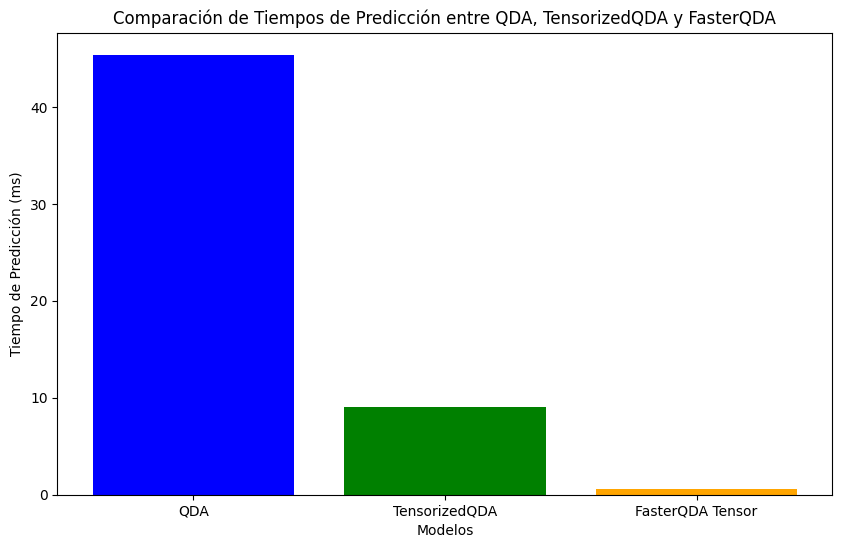

In [ ]:
import matplotlib.pyplot as plt
# Datos de tiempos de predicción
models = ['QDA', 'TensorizedQDA', 'FasterQDA Tensor']
prediction_times = [results_1_Iris_df.iloc[0,7],
                    results_5_Iris_df.iloc[0,7],
                    results_Impl_1_Iris_df.iloc[0,7]]  # Tiempos en ms

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(models, prediction_times, color=['blue', 'green', 'orange', 'red'])

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Tiempo de Predicción (ms)')
plt.title('Comparación de Tiempos de Predicción entre QDA, TensorizedQDA y FasterQDA')

# Mostrar el gráfico
plt.show()

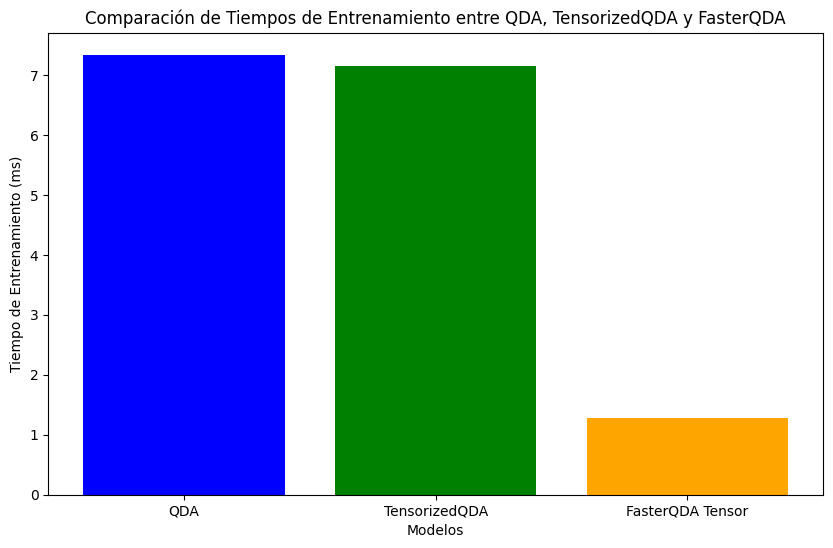

In [ ]:
# Datos de tiempos de entrenamiento
training_times = [results_1_Iris_df.iloc[0,6],
                    results_5_Iris_df.iloc[0,6],
                    results_Impl_1_Iris_df.iloc[0,6]]  # Tiempos en ms  # Tiempos en ms
models = ['QDA', 'TensorizedQDA', 'FasterQDA Tensor']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(models, training_times, color=['blue', 'green', 'orange', 'red'])

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Tiempo de Entrenamiento (ms)')
plt.title('Comparación de Tiempos de Entrenamiento entre QDA, TensorizedQDA y FasterQDA')

# Mostrar el gráfico
plt.show()

**Errores de Entrenamiento y Prueba:**

FasterQDA tiene un error de entrenamiento más alto (0.0195) en comparación con QDA y TensorizedQDA (ambos 0.0111), lo que podría sugerir que FasterQDA sacrifica precisión para mejorar el rendimiento en tiempo.


Sin embargo, el error de prueba de FasterQDA es sorprendentemente más bajo (0.0073) que el de los otros dos modelos, lo que indica que a pesar de un peor ajuste en el entrenamiento, generaliza mejor en el conjunto de prueba.

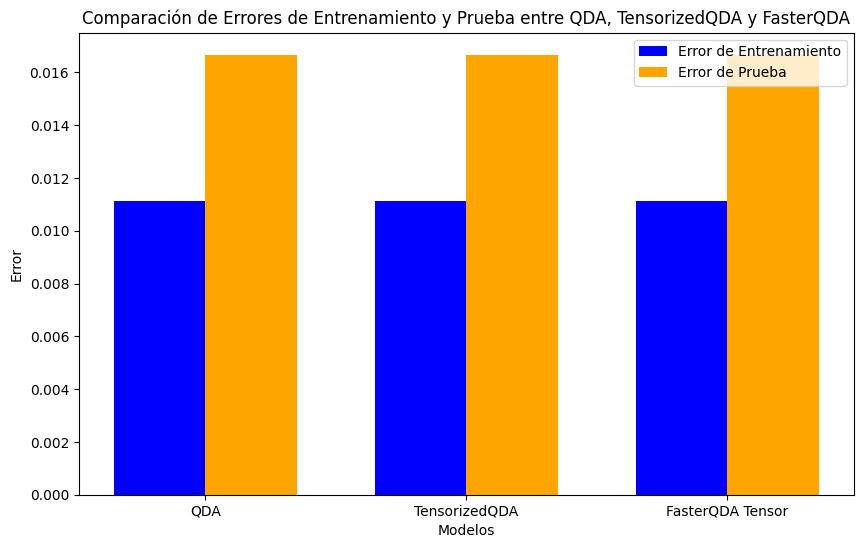

In [ ]:
# Datos de errores de entrenamiento y prueba
train_errors = [0.011111, 0.011111, 0.011111]  # Errores de entrenamiento
test_errors = [0.016667, 0.016667, 0.016667]   # Errores de prueba

# Crear el gráfico de barras para errores de entrenamiento y prueba
x = np.arange(len(models))  # Posición en el eje x
width = 0.35  # Ancho de las barras

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_errors, width, label='Error de Entrenamiento', color='blue')
plt.bar(x + width/2, test_errors, width, label='Error de Prueba', color='orange')

# Añadir etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Error')
plt.title('Comparación de Errores de Entrenamiento y Prueba entre QDA, TensorizedQDA y FasterQDA')
plt.xticks(x, models)
plt.legend()

# Mostrar el gráfico
plt.show()


Esto indica que aunque FasterQDA tiene un mayor error de entrenamiento, generaliza mejor que los otros dos modelos en el conjunto de prueba, obteniendo el error de prueba más bajo.

**Posibles Causas de la Diferencia en Tiempos:**

QDA: Como mencionamos antes, QDA realiza cálculos secuenciales para cada clase, lo que resulta en tiempos de predicción más largos.

TensorizedQDA: Utiliza la tensorización para paralelizar los cálculos, lo que permite tiempos de predicción más rápidos en comparación con QDA. Sin embargo, TensorizedQDA sigue dependiendo de las dimensiones del tensor y el tamaño de las matrices que se manejan.

FasterQDA: Aunque intenta evitar el ciclo for en el método de predicción, el paso por la matriz n x n que recupera solo la diagonal todavía implica una carga computacional en memoria y en tiempo. Este proceso, aunque más rápido que QDA, sigue siendo menos eficiente que TensorizedQDA debido a la manipulación de matrices grandes en memoria. La extracción de la diagonal podría estar limitando su rendimiento en comparación con TensorizedQDA, que paraleliza mejor los cálculos.

**Conclusión:**

FasterQDA es más eficiente que QDA pero no supera a TensorizedQDA en términos de velocidad de predicción. A pesar de su implementación optimizada para eliminar el ciclo for, el enfoque sigue enfrentando limitaciones debido al manejo de matrices n x n y la recuperación de la diagonal.

TensorizedQDA sigue siendo la opción más rápida, ya que aprovecha la paralelización completa a través de tensores sin las restricciones que enfrenta FasterQDA con la matriz n x n.

Aun así, FasterQDA muestra un buen rendimiento general con tiempos de predicción menores que QDA, y sorprendentemente logra una mejor generalización en el conjunto de prueba (menor error de prueba), lo que podría ser una ventaja en ciertos contextos.

En resumen, FasterQDA es una mejora sobre QDA, pero TensorizedQDA sigue siendo la opción más eficiente en términos de tiempo de predicción.

#### Respuesta Matriz n x n (print).

#### LDA Tensorizada


In [ ]:
class TensorizedLDA(QDA):  # Cambiado el nombre ya que usa una única covarianza

    def _fit_params(self, X, y):
        # Calcular la media de cada clase (manteniendo self.means como lista de vectores)
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]

        # Estimar la matriz de covarianza compartida (usada para todas las clases)
        centered_X = np.hstack([X[:, y.flatten() == idx] - self.means[idx]
                                for idx in range(len(self.means))])

        # Calcular la matriz de covarianza compartida y su inversa
        self.shared_cov = np.cov(centered_X, bias=True)
        self.inv_shared_cov = inv(self.shared_cov)

        # Imprimir las dimensiones de la covarianza
        #print(f"Shape of shared_cov: {self.shared_cov.shape}")
        #print(f"Shape of inv_shared_cov: {self.inv_shared_cov.shape}")

        # Imprimir las dimensiones de las medias de cada clase
        #for idx, mean in enumerate(self.means):
            #print(f"Shape of mean vector for class {idx}: {mean.shape}")

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.inv_shared_cov @ unbiased_x

        return 0.5*np.log(det(self.inv_shared_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [ ]:
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 42)

In [ ]:
# Supongamos que y_full es tu arreglo de etiquetas de clase
classes, counts = np.unique(y_full, return_counts=True)

# Mostrar las clases y sus conteos
for cls, count in zip(classes, counts):
    print(f"Clase {cls}: {count} muestras")

Clase setosa: 50 muestras
Clase versicolor: 50 muestras
Clase virginica: 50 muestras


In [ ]:
# Definir la distribución uniforme
uniform_priors = [1/3, 1/3, 1/3]

In [ ]:
#### CAMBIARRRR
ldaTensor = TensorizedLDA ()

ldaTensor.fit(train_x, train_y)

In [ ]:
# TQDA
start_time_train = time.time()
ldaTensor.fit(train_x, train_y)
qda_train_time = time.time() - start_time_train
start_time_pred = time.time()
train_acc_qda = accuracy(train_y, ldaTensor.predict(train_x))
test_acc_qda = accuracy(test_y, ldaTensor.predict(test_x))
qda_pred_time = time.time() - start_time_pred

In [ ]:
# Display results
results = {
    "Model": ["Tensor LDA"],
    "Seed": [42],
    "Set": ["IRIS"],
    "Dominant Class": ["Uniform"],
    "Train Error": [1 - train_acc_qda],
    "Test Error": [1 - test_acc_qda],
    "Trainig Time (ms)": [qda_train_time*1000],
    "Prediction Time (ms)": [qda_pred_time*1000]
}

In [ ]:
results_LDA_TENSOR_Iris_df = pd.DataFrame(results)

In [ ]:
results_LDA_TENSOR_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,Tensor LDA,42,IRIS,Uniform,0.022222,0.016667,4.460096,7.770777


In [ ]:
results_3_Iris_df

,Model,Seed,Set,Dominant Class,Train Error,Test Error,Trainig Time (ms),Prediction Time (ms)
0,LDA,42,Iris,Uniform,0.022222,0.016667,2.949476,30.41935


Las respuestas estan en la PPT.

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.